## Семинар 6 "Segmentation"

ФИО: __Иванов Иван Иванович__

## Задание

Предлагается поучаствовать в конкурсе https://drive.grand-challenge.org/

Для зачета требуется получить значение dice-coefficient на leaderboard не меньше 0.8 и прислать ноутбук с кодом и кратким отчетом: что пробовали, что сделали, мысли почему окончательная архитектура лучше остальных.

Называйте своего юзера с суффиксом [sphere].

Также первые 3 человека получат бонусные 6, 4, 2 балл соответственно. (deadline: 23:59 14 апреля 2019). Скорее всего будут дополнительные плюшки для призеров конкурса.


In [16]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch as t
from torch.utils import data
from torchvision import transforms as tsf
import scipy.misc

from pathlib import Path

from PIL import Image
import skimage
from skimage import io
from IPython.display import clear_output
import sys

TRAIN_PATH = './train.pth'
TEST_PATH = './test.pth'
%matplotlib inline

In [2]:
def process(dataset_path, mask_path=None):
    data = []
    if mask_path:
        mask_path = Path(mask_path)

    for image in sorted(Path(dataset_path).iterdir()):
        item = {}
        img = io.imread(image)
        
        if img.shape[2]>3:
            assert(img[:,:,3]!=255).sum()==0
        
        img = img[:,:,:3]
        item['name'] = image.name.split("_")[0]
        item['img'] = t.from_numpy(img)
        if mask_path:
            mask = io.imread(mask_path/(item['name'] + "_manual1.gif"))
            item['mask'] = t.from_numpy(mask)
        data.append(item)
    
    return data
test = process('test/images/')
t.save(test, TEST_PATH)
train_data = process('training/images', "training/1st_manual/")

C:\Users\karry\Anaconda3\lib\site-packages\imageio\plugins\_tifffile.py:8388: UserWarning: unexpected end of LZW stream (code 0)
  warnings.warn('unexpected end of LZW stream (code %i)' % code)


In [3]:
import PIL
class Dataset():
    def __init__(self,data,source_transform,target_transform):
        self.datas = data
        self.s_transform = source_transform
        self.t_transform = target_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        mask = data['mask'][:,:,None].byte().numpy()
        img = self.s_transform(img)
        mask = self.t_transform(mask)
        return img, mask
    def __len__(self):
        return len(self.datas)
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5,0.5,0.5],std = [0.5,0.5,0.5])
]
)
t_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((128,128),interpolation=PIL.Image.NEAREST),
    tsf.ToTensor(),]
)
dataset = Dataset(train_data,s_trans,t_trans)
dataloader = t.utils.data.DataLoader(dataset,num_workers=2,batch_size=4)

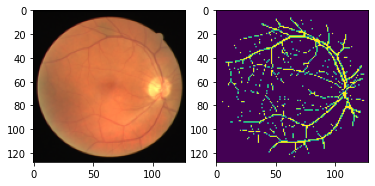

In [4]:
img,mask = dataset[12]
plt.subplot(121)
plt.imshow(img.permute(1,2,0).numpy()*0.5+0.5)
plt.subplot(122)
plt.imshow(mask[0].numpy())

In [5]:
# Попробуйте использовать различные функции потерь.
def soft_dice_loss(inputs, targets):
        num = targets.size(0)
        m1  = inputs.view(num,-1)
        m2  = targets.view(num,-1)
        intersection = (m1 * m2)
        score = 2. * (intersection.sum(1)+1) / (m1.sum(1) + m2.sum(1)+1)
        score = 1 - score.sum()/num
        return score

In [7]:
import keras,os
from keras.models import Model
from keras.layers.merge import add,multiply
from keras.layers import Lambda,Input, Conv2D,Conv2DTranspose,Conv2DTranspose, MaxPooling2D, UpSampling2D,Cropping2D, core, Dropout,normalization,concatenate,Activation
from keras import backend as K
from keras.layers.core import Layer, InputSpec
from keras.layers.advanced_activations import LeakyReLU
#from keras.utils import plot_model

from perception.bases.model_base import ModelBase

#This file is used along with SegmentionModel file, in this file we modified one Conv2D layer with Dense Layer so hence we are adding DenseBlock layer in this file.
class SegmentionModel(ModelBase):
	def __init__(self,config=None):
		super(SegmentionModel, self).__init__(config)

		self.patch_height=config.patch_height
		self.patch_width = config.patch_width
		self.num_seg_class=config.seg_num

		self.build_model()
		self.save()

	def DenseBlock(self,inputs, outdim):

		inputshape = K.int_shape(inputs)
		bn = normalization.BatchNormalization(epsilon=2e-05, axis=3, momentum=0.9, weights=None,
		                                      beta_initializer='zero', gamma_initializer='one')(inputs)
		act = Activation('relu')(bn)
		conv1 = Conv2D(outdim, (3, 3), activation=None, padding='same')(act)

		if inputshape[3] != outdim:
			shortcut = Conv2D(outdim, (1, 1), padding='same')(inputs)
		else:
			shortcut = inputs
		result1 = add([conv1, shortcut])

		bn = normalization.BatchNormalization(epsilon=2e-05, axis=3, momentum=0.9, weights=None,
		                                      beta_initializer='zero', gamma_initializer='one')(result1)
		act = Activation('relu')(bn)
		conv2 = Conv2D(outdim, (3, 3), activation=None, padding='same')(act)
		result = add([result1, conv2, shortcut])
		result = Activation('relu')(result)
		return result

	def build_model(self):
		inputs = Input((self.patch_height, self.patch_width, 1))
		conv1 = Conv2D(32, (1, 1), activation=None, padding='same')(inputs)
		conv1 = normalization.BatchNormalization(epsilon=2e-05, axis=3, momentum=0.9, weights=None,
		                                         beta_initializer='zero', gamma_initializer='one')(conv1)
		conv1 = Activation('relu')(conv1)

		conv1 = self.DenseBlock(conv1, 32)  # 48
		pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

		conv2 = self.DenseBlock(pool1, 64)  # 24
		pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

		conv3 = self.DenseBlock(pool2, 64)  # 12
		pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

		conv4 = self.DenseBlock(pool3, 64)  # 12

		up1 = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(conv4)
		up1 = concatenate([up1, conv3], axis=3)

		conv5 = self.DenseBlock(up1, 64)

		up2 = Conv2DTranspose(64, (3, 3), strides=2, activation='relu', padding='same')(conv5)
		up2 = concatenate([up2, conv2], axis=3)

		conv6 = self.DenseBlock(up2, 64)

		up3 = Conv2DTranspose(32, (3, 3), strides=2, activation='relu', padding='same')(conv6)
		up3 = concatenate([up3, conv1], axis=3)

		conv7 = self.DenseBlock(up3, 32)

		conv8 = Conv2D(self.num_seg_class + 1, (1, 1), activation='relu', padding='same')(conv7)
		# conv6 = normalization.BatchNormalization(epsilon=1e-06, mode=1, axis=-1, momentum=0.9, weights=None, beta_init='zero', gamma_init='one')(conv6)

		# for tensorflow
		conv8 = core.Reshape((self.patch_height*self.patch_width,self.num_seg_class + 1))(conv8)
		# for theano
		#conv8 = core.Reshape(((self.num_seg_class + 1), self.patch_height * self.patch_width))(conv8)
		#conv8 = core.Permute((2, 1))(conv8)
		############
		act = Activation('softmax')(conv8)

		model = Model(inputs=inputs, outputs=act)
		model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
		#plot_model(model, to_file=os.path.join(self.config.checkpoint, "model.png"), show_shapes=True)
		self.model = model

Using TensorFlow backend.


ModuleNotFoundError: No module named 'tensorflow'

In [8]:
dtype=t.FloatTensor

def _epoch(network, loss, loader, optimizer):
    losses = []
    for X, y in loader:
        X = X.type(dtype)
        prediction = network(X)
        loss_batch = loss(prediction, y)
        losses.append(loss_batch.item())
        optimizer.zero_grad()
        loss_batch.backward()
        optimizer.step()
    return losses

def train(network, train_loader, epochs, learning_rate, loss):
    optimizer = t.optim.Adam(network.parameters(), lr=learning_rate)
    train_loss_epochs = []
    network = network.train()
    try:
        for epoch in tqdm(range(epochs)):
            losses = _epoch(network, loss, train_loader, optimizer)
            train_loss_epochs.append(np.mean(losses))
            clear_output(True)
            print('Epoch {0}... Loss: {1:.3f}'.format(
                        epoch, train_loss_epochs[-1]))
            plt.figure(figsize=(12, 5))
            plt.plot(train_loss_epochs)
            plt.xlabel('Epochs', fontsize=16)
            plt.ylabel('Loss', fontsize=16)
            plt.grid()
            plt.show()
    except KeyboardInterrupt:
        if tolerate_keyboard_interrupt:
            pass
        else:
            raise KeyboardInterrupt
    return train_loss_epochs

In [14]:
from torch import nn
import torch.nn.functional as F


class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x


class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x
    
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))
        
        # for padding issues, see 
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = t.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x
    
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        x = t.nn.functional.sigmoid(x)
        return x

In [11]:
X_train = [dataset[i] for i in range (0, 20)]

In [12]:
train_loader = t.utils.data.DataLoader(X_train, batch_size=4, shuffle=True)

Epoch 9... Loss: 0.721


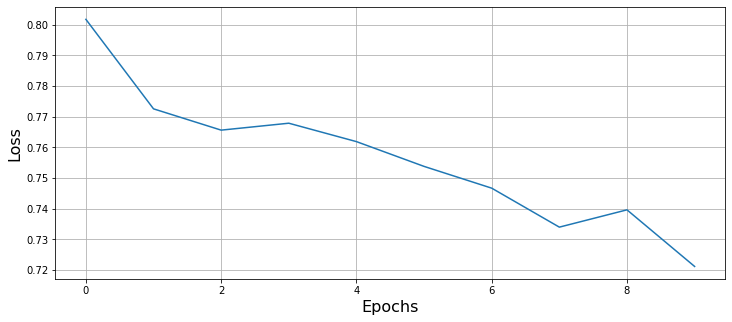


100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [03:41<00:00, 22.45s/it]

[0.8017868638038635,
 0.7725934982299805,
 0.765647006034851,
 0.7679064393043518,
 0.761903989315033,
 0.7538189172744751,
 0.7467180967330933,
 0.7340039491653443,
 0.7396463036537171,
 0.7211800575256347]

In [17]:
model = UNet(3, 1)
train(model, train_loader, 10, 0.01, soft_dice_loss)

In [21]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode
            running_loss = 0.0
            running_corrects = 0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                # zero the parameter gradients
                optimizer.zero_grad()
                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))
            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)
model_ft = model_ft.to(device)
criterion = nn.CrossEntropyLoss()
# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)
# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model = # Your model here

## Results

In [18]:
t.save(model, 'unet10epochs.pth.tar')
s_trans = tsf.Compose([
    tsf.ToPILImage(),
    tsf.Resize((400, 400)),
    tsf.ToTensor(),
    tsf.Normalize(mean = [0.5, 0.5, 0.5],std = [0.5, 0.5, 0.5])
])

class TestDataset():
    def __init__(self,path,source_transform):
        self.datas = t.load(path)
        self.s_transform = source_transform
    def __getitem__(self, index):
        data = self.datas[index]
        img = data['img'].numpy()
        img = self.s_transform(img)
        return img
    def __len__(self):
        return len(self.datas)

testset = TestDataset(TEST_PATH, s_trans)
testdataloader = t.utils.data.DataLoader(testset,batch_size=1)

C:\Users\karry\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type UNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\karry\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type inconv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\karry\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type double_conv. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\karry\Anaconda3\lib\site-packages\torch\serialization.py:360: UserWarning: Couldn't retrieve source code for container of type down. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
C:\Users\karry\

In [22]:
os.makedirs("result")
!zip -r result.zip result

"zip" ­Ґ пў«пҐвбп ў­гваҐ­­Ґ© Ё«Ё ў­Ґи­Ґ©
Є®¬ ­¤®©, ЁбЇ®«­пҐ¬®© Їа®Ја ¬¬®© Ё«Ё Ї ЄҐв­л¬ д ©«®¬.


In [ ]:
import imageio
model = model.eval()
for ex_id, data in enumerate(testdataloader):
    data = t.autograd.Variable(data, volatile=True)
    o = model(data)
    
    source_image = io.imread("test/images/%s_test.tif" % str(ex_id + 1).zfill(2))
    tm = o[0][0].data.cpu().numpy()
    tm = skimage.transform.resize(tm, source_image.shape[:-1])
    tm = (tm > 0.5).astype(int)
    
    imageio.imwrite("result/%s.png" % (ex_id + 1), tm)

C:\Users\karry\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  after removing the cwd from sys.path.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int32 to uint8. Range [0, 1]. Convert image to uint8 prior to saving to suppress this warning.


In [76]:
plt.figure(figsize=(15, 15))
plt.imshow(tm)